# Dynamical Systems

@[Chaoming Wang](mailto:adaduo@outlook.com)
@[Xiaoyu Chen](c-xy17@tsinghua.org.cn)

> What I cannot create, I do not understand.   --- Richard Feynman

THe brain is a complex dynamical system. For efficient dynamics simulation, we provide [`brainpy.DynamicalSystem`](../apis/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst) that can be used to define brain objects with dynamic properties. Various subclasses are implemented to model these objects, such as [brainpy.Channel](../apis/simulation/generated/brainpy.simulation.brainobjects.Channel.rst) for neuron channels, [brainpy.NeuGroup](../apis/simulation/generated/brainpy.simulation.brainobjects.NeuGroup.rst) for neuron groups, [brainpy.TwoEndConn](../apis/simulation/generated/brainpy.simulation.brainobjects.TwoEndConn.rst) for synaptic connections, [brainpy.Network](../apis/simulation/generated/brainpy.simulation.brainobjects.Network.rst) for networks, etc. Arbitrary composition of these objects is also an instance of ``brainpy.DynamicalSystem``. Therefore, ``brainpy.DynamicalSystem`` is the universal language to define dynamical models in BrainPy. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

## ``brainpy.DynamicalSystem``

In this section, the mechanism and the function of ``brainpy.DynamicalSystem`` will be illustrated. 

### What is  a Dynamical System?

First of all, *what can be defined as a dynamical system?*

Intuitively, a `dynamical system` is a system that has time-dependent states. 

Mathematically, it can be expressed as

$$
\dot{X} = f(X, t)
$$

where $X$ is the state of the system, $t$ is the time, and $f$ is a function describing the time dependence of the state. 

Alternatively, the evolution of the system over time can be given by

$$
X(t+dt) = F\left(X(t), t, dt\right)
$$

where $dt$ is the time step and $F$ is the evolution rule to update the system's state.

Accordingly, in BrainPy, any subclass of ``brainpy.DynamicalSystem`` must implement this updating rule in the *update* function ``update(self, _t, _dt)``. A dynamical system may have multiple updating rules, so users can define multiple *update* functions. All updating functions are wrapped into an inner data structure **self.steps** (a Python dictionary specifies the *name* and the *function* of updating rules). Below is a simple example of a dynamical system.

In [2]:
class FitzHughNagumoModel(bp.DynamicalSystem):
    def __init__(self, a=0.8, b=0.7, tau=12.5, **kwargs):
        super(FitzHughNagumoModel, self).__init__(**kwargs)
        
        # parameters
        self.a = a
        self.b = b
        self.tau = tau
        
        # variables
        self.v = bm.Variable([0.])
        self.w = bm.Variable([0.])
        self.I = bm.Variable([0.])
        
    def update(self, _t, _dt):
        # _t : the current time, the system keyword 
        # _dt : the time step, the system keyword 
        
        self.w += (self.v + self.a - self.b * self.w) / self.tau * _dt
        self.v += (self.v - self.v ** 3 / 3 - self.w + self.I) * _dt
        self.I[:] = 0.

Here, we have defined a dynamical system called [FitzHugh–Nagumo neuron model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model), whose dynamics is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

By using the [Euler method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst), this system can be updated by the following rule:

$$
\begin{aligned}
v(t+dt) &= v(t) + [v(t)-{v(t)^{3}/3}-w(t)+RI] * dt, \\
w(t + dt) &= w(t) + [v(t) + a - b w(t)] * dt.
\end{aligned}
$$

We can inspect all update functions in the model by ``xxx.steps``. 

In [3]:
fnh = FitzHughNagumoModel()

fnh.steps  # all update functions

{'update': <bound method FitzHughNagumoModel.update of <__main__.FitzHughNagumoModel object at 0x000001A2D4418B80>>}

### Why use `DynamicalSystem`?

*Why should I define my dynamical system as brainpy.DynamicalSystem?*

There are several benefits of defining a dynamical system as `brainpy.DynamicalSystem`. 

#### 1. A systematic naming system. 

First, every instance of ``DynamicalSystem`` has its unique name.

In [4]:
fnh.name  # name for "fnh" instance

'FitzHughNagumoModel0'

Every instance has its unique name:

In [5]:
for _ in range(3):
    print(FitzHughNagumoModel().name)

FitzHughNagumoModel1
FitzHughNagumoModel2
FitzHughNagumoModel3


Users can also specify the name of a dynamic system:

In [6]:
fnh2 = FitzHughNagumoModel(name='X')

fnh2.name

'X'

In [7]:
# same name will cause error

try:
    FitzHughNagumoModel(name='X')
except bp.errors.UniqueNameError as e:
    print(e)

In BrainPy, each object should have a unique name. However, we detect that <__main__.FitzHughNagumoModel object at 0x000001A2F15B86A0> has a used name "X".


Second, variables, children nodes, etc. inside an instance can be easily accessed by their *absolute* or *relative* path. 

In [8]:
# All variables can be acessed by 
# 1). the absolute path

fnh2.vars()

{'X.I': Variable(DeviceArray([0.], dtype=float32)),
 'X.v': Variable(DeviceArray([0.], dtype=float32)),
 'X.w': Variable(DeviceArray([0.], dtype=float32))}

In [9]:
# 2). or, the relative path

fnh2.vars(method='relative')

{'I': Variable(DeviceArray([0.], dtype=float32)),
 'v': Variable(DeviceArray([0.], dtype=float32)),
 'w': Variable(DeviceArray([0.], dtype=float32))}

If we wrap many instances into a container, i.e. `brainpy.Network`, variables and nodes can also be accessed by their absolute or relative path.

In [10]:
fnh_net = bp.Network(f1=fnh, f2=fnh2)

In [11]:
# absolute access of variables

fnh_net.vars()

{'FitzHughNagumoModel0.I': Variable(DeviceArray([0.], dtype=float32)),
 'FitzHughNagumoModel0.v': Variable(DeviceArray([0.], dtype=float32)),
 'FitzHughNagumoModel0.w': Variable(DeviceArray([0.], dtype=float32)),
 'X.I': Variable(DeviceArray([0.], dtype=float32)),
 'X.v': Variable(DeviceArray([0.], dtype=float32)),
 'X.w': Variable(DeviceArray([0.], dtype=float32))}

In [12]:
# relative access of variables

fnh_net.vars(method='relative')

{'f1.I': Variable(DeviceArray([0.], dtype=float32)),
 'f1.v': Variable(DeviceArray([0.], dtype=float32)),
 'f1.w': Variable(DeviceArray([0.], dtype=float32)),
 'f2.I': Variable(DeviceArray([0.], dtype=float32)),
 'f2.v': Variable(DeviceArray([0.], dtype=float32)),
 'f2.w': Variable(DeviceArray([0.], dtype=float32))}

In [13]:
# absolute access of nodes

fnh_net.nodes()

{'FitzHughNagumoModel0': <__main__.FitzHughNagumoModel at 0x1a2d4418b80>,
 'X': <__main__.FitzHughNagumoModel at 0x1a2f157e700>,
 'Network0': <brainpy.simulation.brainobjects.network.Network at 0x1a2f15b8610>}

In [14]:
# relative access of nodes

fnh_net.nodes(method='relative')

{'': <brainpy.simulation.brainobjects.network.Network at 0x1a2f15b8610>,
 'f1': <__main__.FitzHughNagumoModel at 0x1a2d4418b80>,
 'f2': <__main__.FitzHughNagumoModel at 0x1a2f157e700>}

#### 2. Automatic monitors. 
Any instance of ``brainpy.DynamicalSystem`` can call ``.run(duration)`` for dynamics simulation. During simulation, a [brainpy.Monitor](../apis/simulation/generated/brainpy.simulation.monitor.Monitor.rst) inside the dynamical system (``xxx.mon``) can be used to automatically monitor the history values of the interested variables. Rlease see the tutorial of [Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb) for more details.

In [ ]:
# in "fnh3" instance, we try to monitor "v", "w", and "I" variables
fnh3 = FitzHughNagumoModel(monitors=['v', 'w', 'I'])

# in "fnh4" instance, we only monitor "v" variable
fnh4 = FitzHughNagumoModel(monitors=['v'], name='Y')

#### 3. Convenient input operations. 
During simulation, users can specify the inputs for each model component, with the format of ``(target, value, [type, operation])`` (the details please see the tutorial of [Monitors and Inputs]).(../tutorial_simulation/monitors_and_inputs.ipynb).
    - The ``target`` is the variable accessed by the *absolute* or *relative* path. *Absolute* path access will be very useful in a huge network model.
    - The default input ``type`` is "fix", means the ``value`` must be a constant scalar or array over time. "iter" type of input is also allowed, which means the ``value`` can be an iterable objects (arrays, or iterable functions, etc.). 
    - The default ``operation`` is ``+``, which means the input ``value`` will be added to the ``target``. Allowed operations include ``+``, ``-``, ``*``, ``/``, and ``=``. 

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

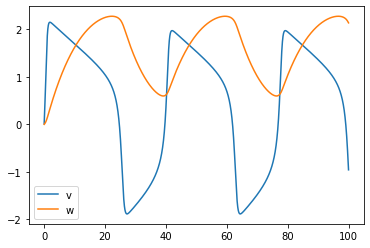

In [17]:
bm.set_dt(dt=0.01)

fnh3.run(duration=100, 
         # relative path to access variable 'I'
         inputs=('I', 1.5))

plt.plot(fnh3.mon.ts, fnh3.mon.v, label='v')
plt.plot(fnh3.mon.ts, fnh3.mon.w, label='w')
plt.legend()

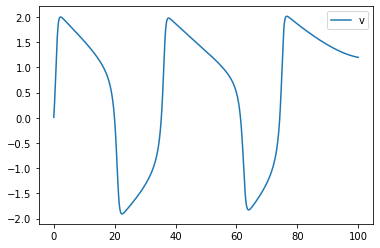

In [18]:
inputs = bm.linspace(1., 2., 10000)

fnh4.run(duration=100, 
         inputs=('Y.I',     #  specify 'target' by the absolute path access
                 inputs,    #  specify 'value' with an iterable array
                 'iter'))   #  "iter" input 'type' must be explicitly specified

plt.plot(fnh4.mon.ts, fnh4.mon.v, label='v')
plt.legend()

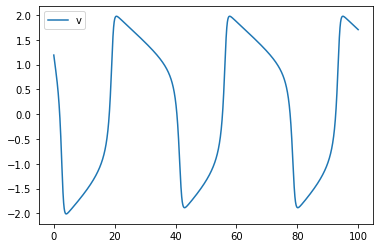

In [19]:
def inputs():
    for i in range(10000): 
        yield 1.5

fnh4.run(duration=100, 
         inputs=('Y.I',     # specify 'target' by the absolute path access
                 inputs(),    # specify 'value' with an iterable function
                 'iter'))   # "iter" input 'type' must be explicitly specified

plt.plot(fnh4.mon.ts, fnh4.mon.v, label='v')
plt.legend()

- ``brainpy.DynamicalSystem`` is a subclass of [brainpy.Base](../apis/generated/brainpy.base.Base.rst), therefore, any instance of ``brainpy.DynamicalSystem`` can be [just-in-time compiled](./jit_compilation.ipynb) into efficient machine codes targeting on CPUs, GPUs, or TPUs. 

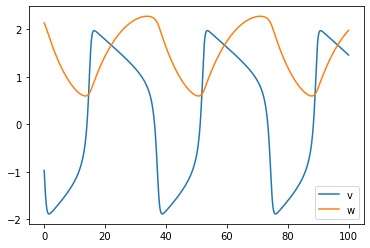

In [20]:
fnh3_jit = bm.jit(fnh3)

fnh3_jit.run(duration=100, inputs=('I', 1.5))

plt.plot(fnh3_jit.mon.ts, fnh3_jit.mon.v, label='v')
plt.plot(fnh3_jit.mon.ts, fnh3_jit.mon.w, label='w')
plt.legend()

- ``brainpy.DynamicalSystem`` can be combined arbitrarily. Any composed system can also benefit from the above convenient interfaces. 

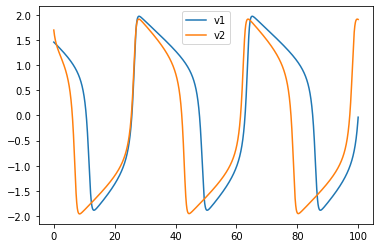

In [21]:
# compose two FitzHughNagumoModel instances into a Network
net2 = bp.Network(f1=fnh3, f2=fnh4, monitors=['f1.v', 'Y.v'])

net2.run(100, inputs=[
    ('f1.I', 1.5), # relative access variable "I" in 'fnh3'
    ('Y.I', 1.0), # absolute access variable "I" in 'fnh4'
])

plt.plot(net2.mon.ts, net2.mon['f1.v'], label='v1')
plt.plot(net2.mon.ts, net2.mon['Y.v'], label='v2')
plt.legend()

In the following sections, defining brain objects (specifically, neurons, synapses, and networks) using the subclasses of ``brainpy.DynamicalSystem`` will be illustrated. 